In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt

We are going to read the energy eigenvalues and dipole matrix elements from .npy files.  We will also still create an instance of the PFHamiltonianGenerator class so we can use its build_pcqed_pf_hamiltonian() method, but it is not really important what details we use to instantiate this class... so we will use LiH in a minimal basis since this is a fast way to instantiate the class!

In [2]:
# # Set the molecule and bond length
# mol = psi4.geometry("""
# 0 1
# O
# H 1 1.0
# """)

# # Optimize the geometry to obtain the new coordinates
# psi4.optimize('scf/cc-pvdz')

# # Get the new optimized coordinates
# new_coordinates = mol.geometry()

# # Print the new coordinates
# print(new_coordinates)

In [3]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/jfoley19/Code/data_repository/Mapol/LiH/PCQED/6-311G/r_1.4/"

# these file names should still be good
E_npy_file = npy_folder + "LiH_r_1.4_6311g_fci_Energies.npy"
Mu_npy_file = npy_folder + "LiH_r_1.4_6311g_fci_Dipoles.npy"

# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)

# print their shape so we know how many elements we have
print(np.shape(E_array))
print(np.shape(Mu_array))
print(E_array)

(250,)
(250, 250, 3)
[-8.01219476 -7.899962   -7.88593596 -7.86104863 -7.86104863 -7.84851087
 -7.84851087 -7.80693549 -7.78459936 -7.76702524 -7.76342939 -7.75827098
 -7.75827098 -7.75123644 -7.75123644 -7.72171149 -7.68303148 -7.53167595
 -7.46183148 -7.44561152 -7.44561152 -7.44122102 -7.41700688 -7.41700688
 -7.41499491 -7.41499491 -7.40506676 -7.40302238 -7.39081209 -7.38221021
 -7.38221021 -7.37219855 -7.37219855 -7.36897222 -7.36897222 -7.35609042
 -7.35609042 -7.33714534 -7.33343267 -7.32130747 -7.31448363 -7.31448363
 -7.306799   -7.306799   -7.30583178 -7.30363511 -7.29983049 -7.29983049
 -7.29710106 -7.28736609 -7.28736609 -7.27939388 -7.27254896 -7.26716866
 -7.26189291 -7.26189291 -7.26028229 -7.26028229 -7.24463063 -7.24419397
 -7.24419397 -7.24111323 -7.23094221 -7.22795844 -7.22795844 -7.2276023
 -7.2276023  -7.21883619 -7.21553431 -7.20683738 -7.20683738 -7.19644038
 -7.18180272 -7.17656251 -7.15921998 -7.15921998 -7.15824942 -7.15347534
 -7.15347534 -7.14947376 -7.149

In [4]:
# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """
    Li
    H 1 1.4
    symmetry c1
"""


options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.025]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236295895
CQED-RHF One-electron energy      = -12.6912246781500926
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0032271304319229
SCF Iteration   1: Energy = -7.8595725022589402   dE = -7.85957E+00   dRMS = 8.01325E-05
SCF Iteration   2: Energy = -7.8595728148569677   dE = -3.12598E-07   dRMS = 9.74325E-06
SCF Iteration   3: Energy = -7.8595728258670885   dE = -1.10101E-08   dRMS = 3.56735E-06
SCF Iteration   4: Energy = -7.8595728281752013   dE = -2.30811E-09   dRMS = 4.53151E-08
SCF Iteration   5: Energy = -7.8595728281752510   dE = -4.97380E-14   dRMS = 1.23024E-10
SCF Iteration   6: Energy = -7.8595728281752510   dE =  0.00000E+00   dRMS = 8.29882E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85957283 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.25357604026794434 seconds
 Completed 1HSO Build in 5.888938903808594e-0

In [5]:
N_R = 21
d_array = np.linspace(0, 20, N_R)
N_l = len(d_array)
N_el = 50
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.025])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_22 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array, Mu_array)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1

In [6]:
# E_pcqed_22 = instance.PCQED_pf_eigs
print(f"Ground state{_pcqed_22[0,0]:.12f}")
#Ground state-8.011624307755

Ground state-8.011624307755


# Perturbation Theory for the Cavity:

$$ \hat{H} = \hat{H}_0 + \lambda \hat{H}' \tag{1} $$

where 

$$\hat{H}_0 = \frac{1}{2} \hat{p}^2 + \frac{1}{2}\omega^2 \hat{q}^2 \tag{2} $$

and 

$$ \hat{H}' = -\omega \hat{d} \hat{q} \tag{3} $$ 

where $\hat{d} = \lambda \cdot \hat{\mu}$, $\hat{p} = i \sqrt{\frac{\hbar \omega}{2}} (\hat{b}^{\dagger} - \hat{b} )$, and $\hat{q} =  \sqrt{\frac{\hbar}{2\omega}} (\hat{b}^{\dagger} + \hat{b} )$.  

Note that this perturbation is the bilinear coupling term, which is often written as 

$$ \hat{H}_{blc} = - \omega \hat{\mu} {\bf A}_0 (\hat{b}^{\dagger} + \hat{b}) \tag{4} $$

with ${\bf A}_0 = \sqrt{\frac{\hbar}{2\omega \epsilon_0 L^3}} \hat{e}$.  Here we have used the fact that $\lambda = \sqrt{\frac{1}{\epsilon_0 L^3}} $ to rewrite this term in the form shown in Eq. 3.


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from numpy import trapz
from scipy.special import hermite
from math import factorial
def compute_alpha(k, mu, hbar):
    """ Helper function to compute \alpha = \sqrt{k * \omega / \hbar}
    
    Arguments
    ---------
    k : float
        the Harmonic force constant
        
    mu : float
        the reduced mass
        
    hbar : float
        reduced planck's constant
        
    Returns
    -------
    alpha : float
        \alpha = \sqrt{k * \omega / \hbar}
    
    """
    # compute omega
    omega = np.sqrt( k / mu )
    
    # compute alpha
    alpha =  mu * omega / hbar
    
    # return alpha
    return alpha

def N(n, alpha):
    """ Helper function to take the quantum number n of the Harmonic Oscillator and return the normalization constant
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    Returns
    -------
    N_n : float
        the normalization constant
    """
    
    return  np.sqrt( 1 / (2 ** n * factorial(n)) ) * ( alpha / np.pi ) ** (1/4) 

def psi(n, alpha, r, r_eq):
    """ Helper function to evaluate the Harmonic Oscillator energy eigenfunction for state n
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    alpha : float
        alpha value
        
    
    r : float
        position at which psi_n will be evaluated
        
    r_eq : float
        equilibrium bondlength
        
    Returns
    -------
    psi_n : float
        value of the harmonic oscillator energy eigenfunction
        
    """
    
    Hr = hermite(n)
    
    psi_n = N(n, alpha) * Hr( np.sqrt(alpha) * ( r - r_eq )) * np.exp( -0.5 * alpha  * (r - r_eq)**2)
    
    return psi_n

def harmonic_eigenvalue(n, k, mu, hbar):
    """ Helper function to evaluate the energy eigenvalue of the harmonic oscillator for state n"""
    
    return hbar * np.sqrt(k/mu) * (n + 1/2)

def morse_eigenvalue(n, k, mu, De, hbar):
    """ Helper function to evaluate the energy eigenvalue of the Morse oscillator for state n"""
    
    omega = np.sqrt( k / mu )
    xi = hbar * omega / (4 * De)

    return hbar * omega * ( (n + 1/2) - xi * (n + 1/2) ** 2)

def potential_matrix_element(n, m, alpha, r, r_eq, V_p):
    """ Helper function to compute <n|V_p|m> where V_p is the perturbing potential
    
    Arguments
    ---------
    n : int
        quantum number of the bra state
        
    m : int
        quantum number of the ket state
        
    alpha : float
        alpha constant for bra/ket states
        
    r : float
        position grid for bra/ket states
        
    r_eq : float
        equilibrium bondlength for bra/ket states
        
    V_p : float
        potential array
        
    Returns
    -------
    V_nm : float
        <n | V_p | m > 
    
    """
    # bra 
    psi_n = psi(n, alpha, r, r_eq)
    
    # ket 
    psi_m = psi(m, alpha, r, r_eq)
    
    # integrand
    integrand = np.conj(psi_n) * V_p * psi_m
    
    # integrate
    V_nm = np.trapz(integrand, r)
    
    return V_nm

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_46918/2353147906.py:8: SyntaxWarning: invalid escape sequence '\s'
  """ Helper function to compute \alpha = \sqrt{k * \omega / \hbar}


In [8]:
# dissociation energy in eV
De_eV = 11.225

# equilibrium bondlength in Angstroms
r_eq_ang = 1.1283

# reduced mass in amu
mu_amu = 6.8606

# potential curvature in inverse angstromgs
beta_inv_ang = 2.5994

# atomic mass units to kg
amu_to_kg = 1.66054e-27

# angstroms to meters
ang_to_m = 1e-10

# electron volts to Jouls
eV_to_J = 1.60218e-19

# electron volts to atomic units of energy (Hartrees)
eV_to_au = 1 / 27.211 #0.0367493

# angstroms to atomic units of length (Bohr radii)
au_to_ang = 0.52917721067121

# atomic mass units to atomic units of mass 
amu_to_au = 1822.89

# dissociation energy in au
De_au = De_eV * eV_to_au

# reduced mass in SI
mu_au = mu_amu * amu_to_au

# equilibrium bondlength in SI
r_eq_au = r_eq_ang / au_to_ang

# beta in SI
beta_au = beta_inv_ang * au_to_ang

# hbar in SI
hbar_au = 1

# h in SI
h_SI = np.pi * 2

def evaluate_Morse(r, De, beta, r_eq):
    """ Helper function to evaluate the Morse potential at a given value of r
    
    Arguments
    ---------
    r : float
        value(s) of r to evaluate potential at
        
    De : float
        dissociation energy of the Morse oscillator
        
    beta : float
        related to the curvature of the Morse oscillator
        
    r_eq : float
        equilibrium bondlength of the Morse oscillator
        
    Returns
    -------
    V_m : float
        value of the Morse potential at value(s) of r
    
    """
    return De * (1 - np.exp(-beta * (r - r_eq))) ** 2


# array of bondlength values
r = np.linspace(0, 2.5 * r_eq_au, 500)

# array of Morse potential values
V_Morse = evaluate_Morse(r, De_au, beta_au, r_eq_au)

In [9]:
# analytical evaluation of k
k = 2 * De_au * beta_au ** 2

# analytical evaluation of g
g = -6 * De_au * beta_au ** 3
print("g is ",g)
# analytical evalution of h
h = 14 * De_au * beta_au ** 4

# numerical evaluation of k

# small displacement along r
delta_r = 0.001 * r_eq_au

# value of Morse potential at forward displacement
V_f = evaluate_Morse(r_eq_au + delta_r, De_au, beta_au, r_eq_au)

# value of Morse potential at equilibrium
V_eq = evaluate_Morse(r_eq_au, De_au, beta_au, r_eq_au)

# value of Morse potential at backward displacement
V_b = evaluate_Morse(r_eq_au - delta_r, De_au, beta_au, r_eq_au)

# CFD approximation to k
k_num = (V_f - 2 * V_eq + V_b) / delta_r ** 2

# compare the numerical and analytic evaluation of k
print(k_num, k)
if np.isclose(k, k_num):
    print(" The numerical and analytical values for k agree to within +/- 0.0001 atomic units.")
    

g is  -6.441927604676426
1.5610705004791825 1.561062667389548
 The numerical and analytical values for k agree to within +/- 0.0001 atomic units.


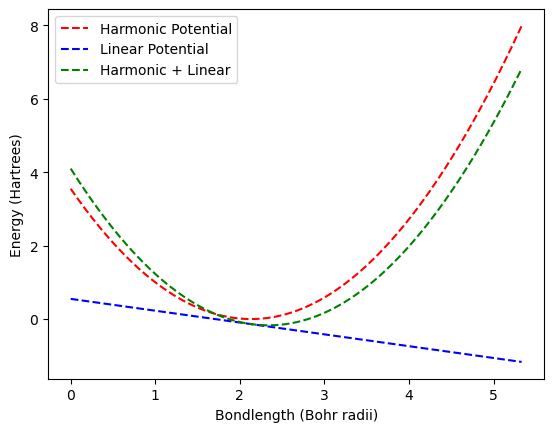

In [10]:
# Harmonic potential
V_H = 1/2 * k * (r -r_eq_au) ** 2

# linear
V_L =  0.05 * g * (r - 0.8*r_eq_au)


#plt.plot(r, V_Morse, 'purple', label="Morse Potential")
plt.plot(r, V_H, 'r--', label="Harmonic Potential")
plt.plot(r, V_L, 'b--', label="Linear Potential")
plt.plot(r, V_H + V_L, 'g--', label="Harmonic + Linear")
#plt.xlim(0.5 * r_eq_au, 2.5 * r_eq_au)
#plt.ylim(0, 1)
plt.xlabel("Bondlength (Bohr radii)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_46918/2282057659.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(r, psi_0, label='$\psi_0$')


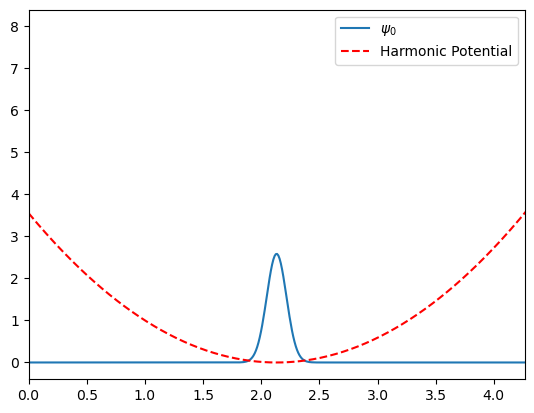

In [11]:
# compute alpha
alpha = compute_alpha(k, mu_au, hbar_au)

# compute psi_0 along the r grid
psi_0 =psi(0, alpha, r, r_eq_au)

# is it normalized?
Integral = trapz(psi_0 ** 2, r)

assert np.isclose(Integral, 1.0)


# Harmonic potential
plt.plot(r, psi_0, label='$\psi_0$')
plt.plot(r, V_H, 'r--', label="Harmonic Potential")
plt.xlim(0, 2 * r_eq_au)
plt.legend()
plt.show()

In [12]:
# fundamental transition energy at HO level
fundamental_HO = harmonic_eigenvalue(1, k, mu_au, hbar_au) - harmonic_eigenvalue(0, k, mu_au, hbar_au)

# fundamental transition energy at Morse level
fundamental_Morse = morse_eigenvalue(1, k, mu_au, De_au, hbar_au) - morse_eigenvalue(0, k, mu_au, De_au, hbar_au)

# 1st order correction using the cubic potential
pt1_linear = potential_matrix_element(0, 0, alpha, r, r_eq_au, V_L)

# 2nd order corrections using cubic and quartic potentials
pt2_linear = 0

# sum over |<j|V'|n>|^2/(Ej-En)
for j in range(1, 100):
    E_j = harmonic_eigenvalue(j, k, mu_au, hbar_au)
    Vc_j0 = potential_matrix_element(j, 0, alpha, r, r_eq_au, V_L)
    pt2_linear += Vc_j0 ** 2 / (fundamental_HO - E_j)
 
       

In [13]:
print(F' Pt1 Linear is {pt1_linear}')
print(F' Pt2 Linear is {pt2_linear}')


 Pt1 Linear is -0.1373533623478818
 Pt2 Linear is -0.06645862483741127


In [14]:
expected_correction = -0.0664586248374112

assert np.isclose((pt2_linear), expected_correction)